Look at ONC patrol data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import datetime
import netCDF4 as nc
import seaborn as sns
import glob

import JEMS

from salishsea_tools import tidetools, viz_tools

%matplotlib inline

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def find_data_line(csvfilename):
    """ Look up line number where data beings in csvfilename.
    Assumes first line without # in the front is the data
    
    :arg csvfilename: name of file
    :type csvfilename: string
    
    :returns: data_line, the line number of the data.
    """
    l = open(csvfilename, 'r')

    for i, line in enumerate(l):
        if "#" not in line:
            data_line = i
            break
    l.close()
    
    return data_line

In [3]:
def find_column_names(csvfilename, data_line):
    """Find the columns in an ONC csv file.
    Assumes column names are the line before two lines before data_line
    
    :arg csvfilename: name of file
    :type csvfilename: string
    
    :arg data_line: line number where the data begins
    :type data_lins: nonnegative integer
    
    :returns: columns
    line number of data start and list of column names
    """
    columns = pd.read_csv(csvfilename, skiprows=data_line-2, nrows=1,
                          header=None, skipinitialspace=True, dtype=str)
    columns = np.array(columns)[0]
    columns[0] = columns[0].replace('#', '')
    columns[0] = columns[0].replace('"', '')
    
    return columns


In [4]:
def load_patrol_csv(csvfilename):
    """Loads data contained in ONC patrol csv.
    
    :arg csvfilename: name of file
    :type csvfilename: string
    
    :returns: data, a pandas dataframe
    """
    
    data_line = find_data_line(csvfilename)
    columns = find_column_names(csvfilename, data_line)
    data = pd.read_csv(csvfilename, header=None, skiprows=data_line,
                       names=columns, parse_dates=[0], low_memory=False)
    data = data.convert_objects(convert_numeric=True)
    data.rename(columns={'Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)': 'time'},
                inplace=True)
    data['day'] = [datetime.datetime(d.year, d.month, d.day) for d in data.time]
    return data

In [5]:
csvfile = '/ocean/nsoontie/MEOPAR/ONC/Patrols/Victoria_Patrol9_CTD_20150220T182104Z_20151001T195734Z-Corrected.csv'
data_line = find_data_line(csvfile)
print(data_line)
columns = find_column_names(csvfile, data_line)
print(columns)
data=load_patrol_csv(csvfile)

59
['Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)'
 'Absolute Pressure Corrected (decibar)'
 'Absolute Pressure Corrected QC Flag  ' 'Conductivity Corrected (S/m)'
 'Conductivity Corrected QC Flag  ' 'Density Corrected (kg/m3)'
 'Density Corrected QC Flag  ' 'Depth Corrected (m)'
 'Depth Corrected QC Flag  ' 'Practical Salinity Corrected (psu)'
 'Practical Salinity Corrected QC Flag  ' 'Pressure Corrected (decibar)'
 'Pressure Corrected QC Flag  ' 'Sound Speed Corrected (m/s)'
 'Sound Speed Corrected QC Flag  ' 'Temperature Corrected (C)'
 'Temperature Corrected QC Flag  ' 'Latitude Corrected (deg)'
 'Latitude Corrected QC Flag  ' 'Longitude Corrected (deg)'
 'Longitude Corrected QC Flag  ']


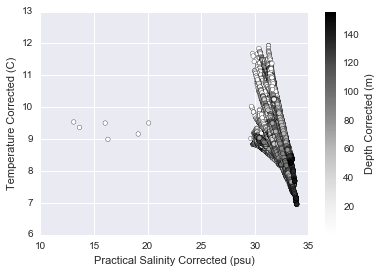

In [6]:
fig,ax=plt.subplots(1,1)
data.plot(x='Practical Salinity Corrected (psu)', y='Temperature Corrected (C)',
          c='Depth Corrected (m)',kind='scatter',ax=ax)
#ax.set_ylim([200,0])

### Isolate a day

In [12]:
def list_days(data):
    """List the days """
    data_days = data.groupby(data.day)
    days= list(data_days.groups.keys())
    return data_days, days

In [13]:
data_days, days = list_days(data)

In [15]:
day =data_days.get_group(days[13]).dropna()

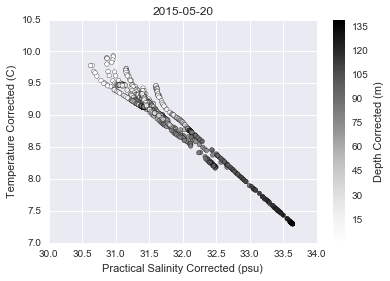

In [16]:
fig,ax=plt.subplots(1,1)
day.plot(x='Practical Salinity Corrected (psu)', y='Temperature Corrected (C)',
         c='Depth Corrected (m)',kind='scatter',ax=ax)
ax.set_title(day.time.min().strftime('%Y-%m-%d'))

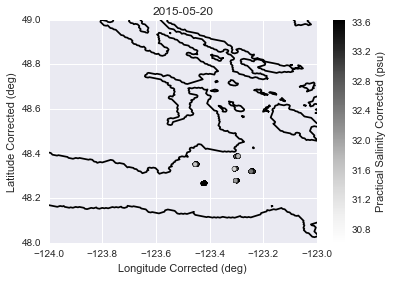

In [17]:
fig,ax=plt.subplots(1,1)
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
day.plot(x='Longitude Corrected (deg)', y='Latitude Corrected (deg)',
         c='Practical Salinity Corrected (psu)',kind='scatter',ax=ax)
viz_tools.plot_coastline(ax,grid_B,coords='map')
ax.set_ylim([48,49])
ax.set_xlim([-124,-123])
ax.set_title(day.time.min().strftime('%Y-%m-%d'))

Plan
* If I can isolate a day in this data set, then I can know which nowcast file to open for comparison.
* For each data point in a day, look up model grid location, interpolate to observed depth, then do scatter? error bars can be daily min/max. Plotted value can be daily average.
* It would be nice if I could separate each cast. Perhaps there is some kind of tolerance that I can apply to the lat/lon? 